# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Основная задача — установить параметры.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

Импортирование необходимых библиотек.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

Чтение и знакомство с данными.

In [126]:
real_estate_df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
real_estate_df.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Описание данных:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

In [127]:
real_estate_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [128]:
real_estate_df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [129]:
nan_values = real_estate_df.isna().sum().sum()
all_values = real_estate_df.shape[0] * real_estate_df.shape[1] # количество значений с учетом nan
print('Процент пропущенных значений в датафрейме: {:.2%}'.format(nan_values / all_values))

Процент пропущенных значений в датафрейме: 19.46%


### Вывод

Всего в данных присутствует 23699 записей и 22 характеристики. Многие харктеристики имеют неоптимизированные типы данных для хранения соответствующих значений. Помимо прочего, в данных присутствует большое количество пропусков (почти 20% от всех значений в датафрейме). 

### Предобработка данных

Пройдемся по данным слева направо и последовательно избавим все характеристики от аномальных значений. Также, по возможности, восполним пропущенные значения на основании уже имеющихся данных.

Столбец ceiling_height. Для того, чтобы заполнить пропущенные значения высоты потолков был выбран метод группировки по количеству этажей в здании и нахождению среднего арифметического высоты потолка для каждого количества этажей.

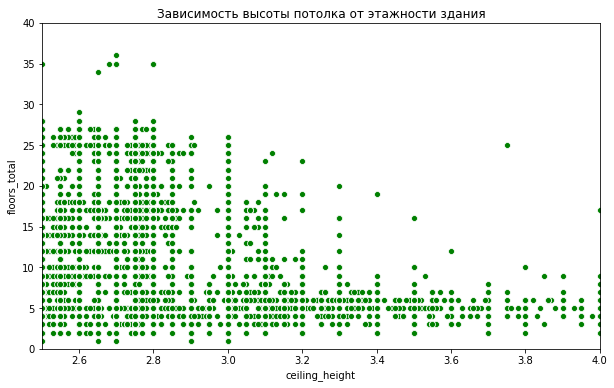

In [130]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='ceiling_height', y='floors_total', data=real_estate_df, color='g')
plt.title('Зависимость высоты потолка от этажности здания')
plt.ylim(0,40)
plt.xlim(2.5,4)
plt.show()

Таким образом, видно, что у зданий с большим количеством этажей нет квартир с высокими потолками, а у низких зданий присутствуют квартиры равно как с высокими, так и с низкими потолками.

In [131]:
floor_ceil_dict = dict(real_estate_df.groupby('floors_total')['ceiling_height'].mean())
floor_ceil_dict

{1.0: 2.7399999999999998,
 2.0: 3.0067906976744188,
 3.0: 2.9694736842105263,
 4.0: 2.9868314321926475,
 5.0: 2.7931914893617202,
 6.0: 3.1207431340872356,
 7.0: 2.9469597989949734,
 8.0: 2.8568181818181824,
 9.0: 2.599092686742307,
 10.0: 2.6851999999999934,
 11.0: 2.782385321100917,
 12.0: 2.640257913247364,
 13.0: 2.7154700854700855,
 14.0: 2.731545189504375,
 15.0: 2.7148444444444446,
 16.0: 2.74750289017341,
 17.0: 2.7491451292246514,
 18.0: 2.7045818181818166,
 19.0: 2.778731343283581,
 20.0: 2.756858974358974,
 21.0: 2.711692307692308,
 22.0: 2.7315602836879433,
 23.0: 2.7537755102040817,
 24.0: 2.851566820276498,
 25.0: 2.7765965583173973,
 26.0: 2.7092592592592593,
 27.0: 2.6755555555555537,
 28.0: 2.5944444444444446,
 29.0: 2.6,
 33.0: nan,
 34.0: 2.65,
 35.0: 2.7099999999999995,
 36.0: 14.85,
 37.0: 1.75,
 52.0: 2.65,
 60.0: 2.88}

Мы видим, что есть зависимость средней высоты потолка от этажности здания. Помимо прочего, у зданий высотой 33 этажа нет значения и логичнее всего заполнить его средней высотой двух ближайших соседей - 29 и 34 соответсвенно.

In [132]:
floor_ceil_dict[33] = (floor_ceil_dict[29] + floor_ceil_dict[33]) / 2

В датасете есть строчки, где отсутствуют и высота, и количество этажей. Помимо прочего, строчек с неизвестной этажность всего 86 и их можно безболезненно удалить.

In [133]:
real_estate_df.dropna(subset=['floors_total'], inplace=True)

Теперь заполним пропущенные значения ceiling_height.

In [134]:
real_estate_df.loc[real_estate_df['ceiling_height'].isnull(), 'ceiling_height'] = real_estate_df[real_estate_df['ceiling_height'].isnull()].apply(lambda x: floor_ceil_dict[x['floors_total']], axis=1)

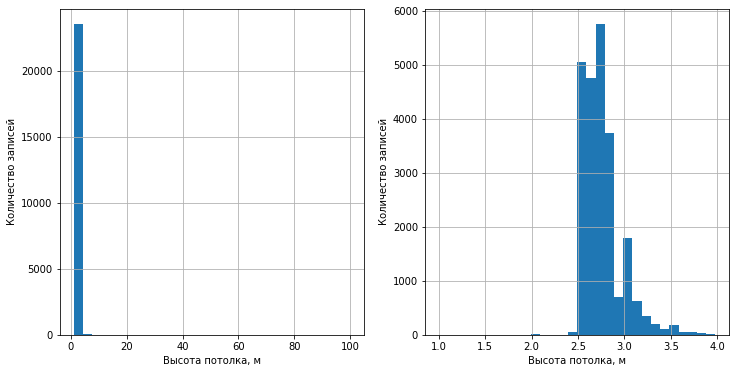


Количество записей с высотой потолка больше 4 метров: 76

Количество записей с высотой потолка меньше 2.5 метров: 73


In [135]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
real_estate_df['ceiling_height'].plot(kind='hist', grid=True, bins=30)
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество записей')
plt.subplot(1, 2, 2)
real_estate_df[real_estate_df['ceiling_height'] < 4]['ceiling_height'].plot(kind='hist', grid=True, bins=30)
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество записей')
plt.show()
print('\nКоличество записей с высотой потолка больше 4 метров: {}'.format(len(real_estate_df[real_estate_df['ceiling_height'] > 4])))
print('\nКоличество записей с высотой потолка меньше 2.5 метров: {}'.format(len(real_estate_df[real_estate_df['ceiling_height'] < 2.5])))

In [136]:
real_estate_df = real_estate_df[(real_estate_df['ceiling_height'] >= 2.5) & (real_estate_df['ceiling_height'] < 4)]

living_area. Посмотрим на зависимость этой характеристики от некоторых других столбцов.

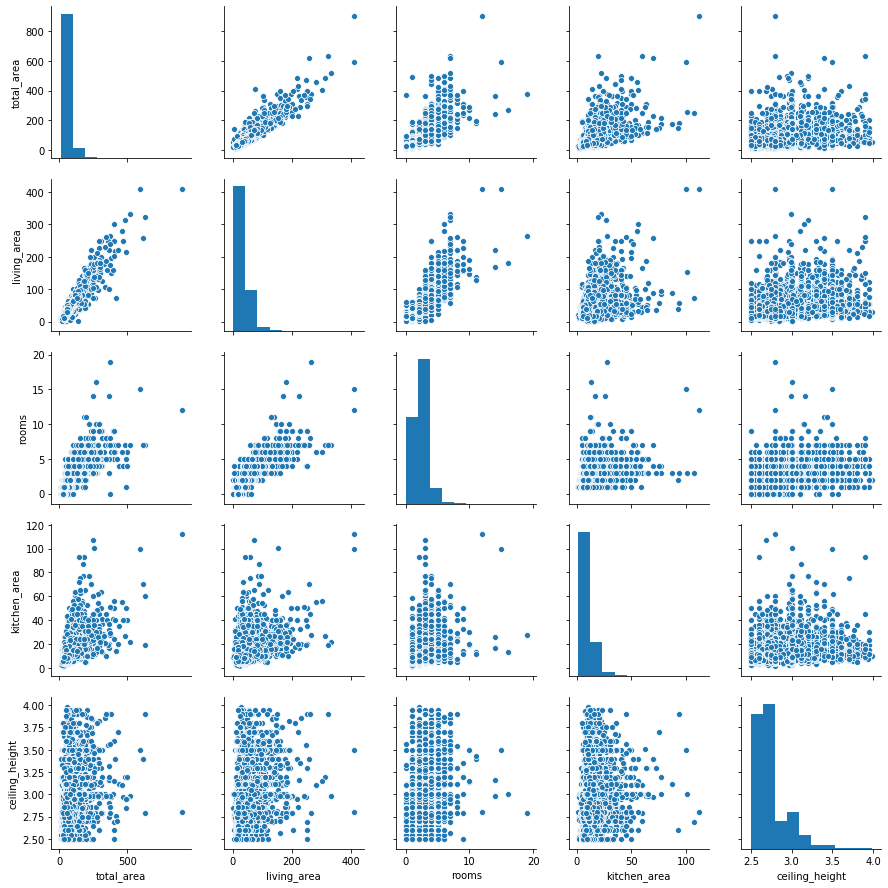

In [137]:
sns.pairplot(real_estate_df[['total_area', 'living_area', 'rooms', 'kitchen_area', 'ceiling_height']])

living_area показывает наиболее четкую корреляцию с total_area. Построим график для большей детализации.

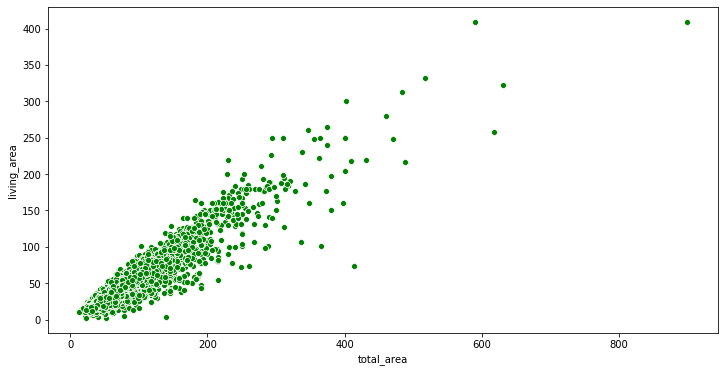

In [138]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='total_area', y='living_area', data=real_estate_df, color='g')
plt.show()

Видим прямую линейную зависимость. Заполним недостающие данные столбца living_area умножив соответствующее значение total_area на усредненное отношение living_area к total_area.

In [139]:
living_area_filler = (real_estate_df[~real_estate_df['living_area'].isnull()]['living_area'] / real_estate_df[~real_estate_df['living_area'].isnull()]['total_area']).mean()

real_estate_df.loc[real_estate_df['living_area'].isnull(), 'living_area'] =\
                                                    real_estate_df[real_estate_df['living_area'].isnull()]\
                                                    .apply(lambda x: x['total_area'] * living_area_filler, axis=1)

Посмотрим на столбец is_apartment.

In [140]:
real_estate_df['is_apartment'].value_counts()

False    2691
True       43
Name: is_apartment, dtype: int64

Поскольку здесь присутсвуют как знаяения True, так и False, то однозначно сказать, что пустые значения относятся к False (то есть их просто не заполнили, потому что квартира/дом не относится к апартаментам) нельзя. Более того, отсутствующих значений намного больше, чем заполненных, поэтому следует исключить этот столбец из датафрейма.

In [141]:
real_estate_df = real_estate_df.drop('is_apartment', axis=1)

kitchen_area. Из pairplot графика, представленного выше, видно, что зависимость выражена слабо, а сам параматер достаточно важен при оценке стоимости квартиры. Посмотрим, сколько % от всего датафрейма занимают пропущенные значения.

In [142]:
kitchen_are_missed = len(real_estate_df[real_estate_df['kitchen_area'].isnull()]['kitchen_area'])
print('Процент пропущенных значений в столбце kitchen_area: {:.2%}'.format(kitchen_are_missed / len(real_estate_df)))


Процент пропущенных значений в столбце kitchen_area: 9.43%


Обидно удалять почти 10% данных, но для того, чтобы сохранить их качество придется это сделать.

In [143]:
real_estate_df = real_estate_df.dropna(subset=['kitchen_area'])

Осталась последняя характеристика из тех данных, которые мы получили от людей - количество балконов (balcony).

In [144]:
kitchen_area_missed = len(real_estate_df[real_estate_df['balcony'].isnull()]['balcony'])
print('Процент пропущенных значений в столбце balcony: {:.2%}'.format(kitchen_area_missed / len(real_estate_df)))

Процент пропущенных значений в столбце balcony: 46.57%


In [145]:
real_estate_df['balcony'].value_counts()

1.0    4002
2.0    3429
0.0    3361
5.0     292
4.0     176
3.0      76
Name: balcony, dtype: int64

Чаще всего встречаются квартиры с 1 балконом, однако здесь не учтены пропущенные значения, которых 46,5%. Поскольку эти данные заполнял человек, а балконов всегда какое-то конкретное количество, которое влияет на цену, то обычно их указывают. Вряд ли на месте пропущенного значения может быть 4 или 5 балконов, ведь эти данные очень важны. Соответственно, скорее всего человек оставил эту графу пустой, если балконов у него нет. Заменим все пропущенные значения на нули.

In [146]:
real_estate_df['balcony'].fillna(value=0, inplace=True)

Остались только те данные, которые собирались автоматически. Среди них достаточно много пропущенных значений, которые неясно как трактовать. Сами же данные друг от друга зависят слабо и не сильно влияют на цену жилья, кроме относительно заполненного расстояния до центра (cityCenters_nearest). Поэтому работать с количественными данными не имеет особого смысла. Однако, следует посмотреть категориальные (locality_name).

In [147]:
locality_name_missed = len(real_estate_df[real_estate_df['locality_name'].isnull()]['locality_name'])
print('Процент пропущенных значений в столбце balcony: {:.2%}\n\n'.format(locality_name_missed / len(real_estate_df)))
print(real_estate_df['locality_name'].unique())

Процент пропущенных значений в столбце balcony: 0.18%


['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Колпино' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный'
 'деревня Старая' 'деревня Лесколово' 'село Путилово' 'Ивангород' 'Мурино'
 'Сланцы' 'Шлиссельбург' 'Сясьстрой' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'поселок Новый Свет' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'п

Помимо большого разнообразия уникальных значений есть и несколько пропущенных, которые можно удалить.

In [148]:
real_estate_df.dropna(subset=['locality_name'], inplace=True)

Теперь приступим к сокращению уникальных значений, из которых видно, что все города начинаются с большой буквы и не имеют ничего, кроме названия города, поселки и деревни содержат соответсвующие слова в предложении. Помимо этих трёх крупных категорий есть много мелких, которые можно занести в 'другое'.

In [149]:
def locality_name_changer(row):
    words_in_row = row.split()
    if 'посёлок' in words_in_row or 'поселок' in words_in_row:
        return 'Посёлок'
    elif 'деревня' in words_in_row:
        return 'Деревня'
    elif words_in_row[0][0].isupper(): # первая буква в слове
        return 'Город'
    else:
        return 'Другое'

In [150]:
real_estate_df['locality_type'] = real_estate_df['locality_name'].apply(locality_name_changer)
real_estate_df['locality_type'].value_counts()

Город      18018
Посёлок     2320
Деревня      809
Другое        30
Name: locality_type, dtype: int64

Давайте взглянем на общую иформацию по датафрейму.

In [151]:
real_estate_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21177 entries, 0 to 23698
Data columns (total 22 columns):
total_images            21177 non-null int64
last_price              21177 non-null float64
total_area              21177 non-null float64
first_day_exposition    21177 non-null object
rooms                   21177 non-null int64
ceiling_height          21177 non-null float64
floors_total            21177 non-null float64
living_area             21177 non-null float64
floor                   21177 non-null int64
studio                  21177 non-null bool
open_plan               21177 non-null bool
kitchen_area            21177 non-null float64
balcony                 21177 non-null float64
locality_name           21177 non-null object
airports_nearest        16403 non-null float64
cityCenters_nearest     16421 non-null float64
parks_around3000        16422 non-null float64
parks_nearest           7285 non-null float64
ponds_around3000        16422 non-null float64
ponds_nearest

Теперь, пользуюсь табличкой, полученной из датафрема методом describe(), с учетом минимального и максимального знаений тех или иных характеристик следует оптимизровать типы данных количественных переменных.

In [152]:
real_estate_df = real_estate_df.astype({'total_images': np.uint8,
                                        'last_price': np.int32,
                                        'total_area': np.float16,
                                        'rooms': np.uint8,
                                        'ceiling_height': np.float16,
                                        'floors_total': np.uint8,
                                        'living_area': np.float16,
                                        'floor': np.uint8,
                                        'kitchen_area': np.float16,
                                        'balcony': np.uint8})

- int8 - Целые числа в диапазоне от -128 по 127 (числа размером 1 байт)

- uint8 - Целые числа в диапазоне от 0 по 255 (числа размером 1 байт)

- float16 - Числа с плавающей точкой от -65504.0 по 65504.0 (числа размером 2 байта)

- int32 - Целые числа в диапазоне от -2147483648 по 2147483647 (числа размером 4 байта)

In [153]:
real_estate_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21177 entries, 0 to 23698
Data columns (total 22 columns):
total_images            21177 non-null uint8
last_price              21177 non-null int32
total_area              21177 non-null float16
first_day_exposition    21177 non-null object
rooms                   21177 non-null uint8
ceiling_height          21177 non-null float16
floors_total            21177 non-null uint8
living_area             21177 non-null float16
floor                   21177 non-null uint8
studio                  21177 non-null bool
open_plan               21177 non-null bool
kitchen_area            21177 non-null float16
balcony                 21177 non-null uint8
locality_name           21177 non-null object
airports_nearest        16403 non-null float64
cityCenters_nearest     16421 non-null float64
parks_around3000        16422 non-null float64
parks_nearest           7285 non-null float64
ponds_around3000        16422 non-null float64
ponds_nearest      

Датафрейм стал не намного легче, все потому что есть характеристика first_day_exposition, которая является типом datetime, но записана как object. Переведем ее в формат datetime и проверим насколько легче стал датафрейм.

In [154]:
real_estate_df['first_day_exposition'] = pd.to_datetime(real_estate_df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
real_estate_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21177 entries, 0 to 23698
Data columns (total 22 columns):
total_images            21177 non-null uint8
last_price              21177 non-null int32
total_area              21177 non-null float16
first_day_exposition    21177 non-null datetime64[ns]
rooms                   21177 non-null uint8
ceiling_height          21177 non-null float16
floors_total            21177 non-null uint8
living_area             21177 non-null float16
floor                   21177 non-null uint8
studio                  21177 non-null bool
open_plan               21177 non-null bool
kitchen_area            21177 non-null float16
balcony                 21177 non-null uint8
locality_name           21177 non-null object
airports_nearest        16403 non-null float64
cityCenters_nearest     16421 non-null float64
parks_around3000        16422 non-null float64
parks_nearest           7285 non-null float64
ponds_around3000        16422 non-null float64
ponds_neare

Итого, с 8.6 Мб до 5.9 Мб, а это целых 32%. 

## Вывод

Все необходимые данные для расчета ключевых показателей были обработаны с общей потерей в чуть более 12,5%. Типы данных были оптимизированны в результате чего объем памяти датафрейма снизился на 32%. Также были исключены некоторые аномальные значения. Из столбца locality_name были получены 4 категориальные переменные, характеризующие местонахождение продаваемого жилья. Столбец first_day_exposition был переведен в формат datetime. Тепер данные готовы для дальнейшего анализа.

### Посчитаем и добавим в таблицу дополнительную информацию

Добавим в таблицу цену квадратного метра. Для этого поделим цену на общую площадь.

In [155]:
real_estate_df['price_per_m2'] = real_estate_df['last_price'] / real_estate_df['total_area']

Добавим год, месяц и день публикации объявления о продаже.

In [156]:
real_estate_df['publication_year'] = pd.DatetimeIndex(real_estate_df['first_day_exposition']).year
real_estate_df['publication_month'] = pd.DatetimeIndex(real_estate_df['first_day_exposition']).month
real_estate_df['publication_day'] = pd.DatetimeIndex(real_estate_df['first_day_exposition']).day
real_estate_df['publication_year'] = real_estate_df['publication_year'].astype(np.uint16)
real_estate_df['publication_month'] = real_estate_df['publication_month'].astype(np.uint8)
real_estate_df['publication_day'] = real_estate_df['publication_day'].astype(np.uint8)

Добавим категориальную переменную для количества этажей в здании

In [157]:
def floor_changer(row):
    if row['floor'] == 1:
        return 'Первый'
    elif row['floor'] == row['floors_total']:
        return 'Последний'
    else:
        return 'Другой'

In [158]:
real_estate_df['floor_type'] = real_estate_df.apply(floor_changer, axis=1)

Необходимые для анализа и выявления закономерностей континуальные и категориальные переменные получены. Можно продолжать анализ.

### Проведем исследовательский анализ данных

Построим гистограммы площади жилого помещения, его цены, числа комнат и высоты потолков.

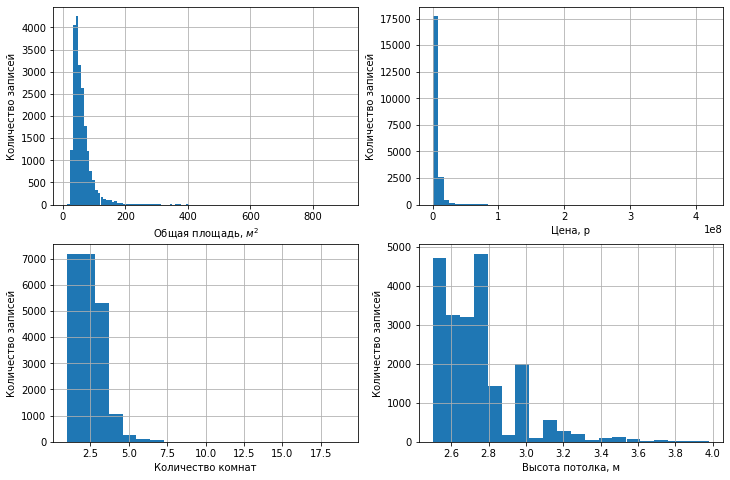

In [159]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
real_estate_df['total_area'].plot(kind='hist', grid=True, bins=100)
plt.xlabel('Общая площадь, $м^2$')
plt.ylabel('Количество записей')
plt.subplot(2, 2, 2)
real_estate_df['last_price'].plot(kind='hist', grid=True, bins=50)
plt.xlabel('Цена, р')
plt.ylabel('Количество записей')
plt.subplot(2, 2, 3)
real_estate_df['rooms'].plot(kind='hist', grid=True, bins=20)
plt.xlabel('Количество комнат')
plt.ylabel('Количество записей')
plt.subplot(2, 2, 4)
real_estate_df['ceiling_height'].plot(kind='hist', grid=True, bins=20)
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество записей')
plt.show()

У всех гистограмм тяжелый хвост, поэтому изучим выбивающиеся значения.

In [160]:
print('Количество жилых объектов с общей площадью более 400 кв.м: {}'.format(len(real_estate_df.query('total_area > 200'))))
print('Количество жилых объектов с общей площадью менее 25 кв.м: {}'.format(len(real_estate_df.query('total_area < 25'))))
print('Количество жилых объектов стоимостью менее 1 млн.р: {}'.format(len(real_estate_df.query('last_price < 1000000'))))
print('Количество жилых объектов стоимостью более 35 млн.р: {}'.format(len(real_estate_df.query('last_price > 35000000'))))
print('Количество жилых объектов с более чем 7 комнатами: {}'.format(len(real_estate_df.query('rooms > 7'))))
print('Количество жилых объектов с высотой потолка более 3.5м: {}'.format(len(real_estate_df.query('ceiling_height > 3.5'))))

Количество жилых объектов с общей площадью более 400 кв.м: 180
Количество жилых объектов с общей площадью менее 25 кв.м: 38
Количество жилых объектов стоимостью менее 1 млн.р: 178
Количество жилых объектов стоимостью более 35 млн.р: 198
Количество жилых объектов с более чем 7 комнатами: 26
Количество жилых объектов с высотой потолка более 3.5м: 180


Избавимся от этих данных методом query()

In [161]:
real_estate_df = real_estate_df.query('25 <= total_area <= 200 & 1000000 < last_price < 35000000 & rooms <= 7 & ceiling_height <= 3.5')

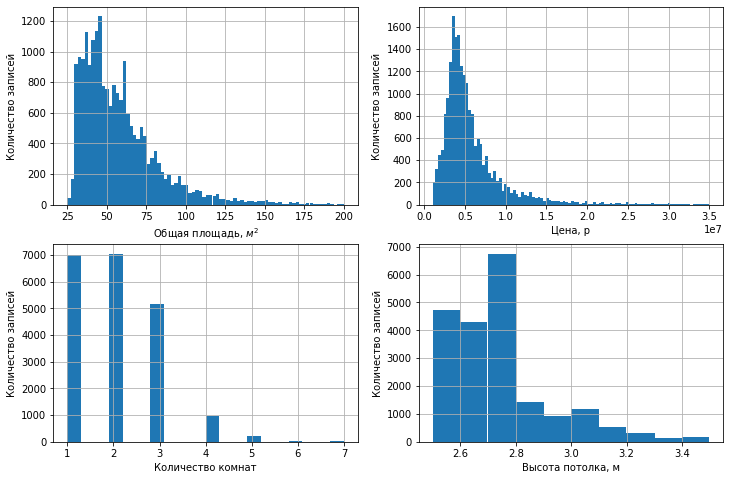

In [162]:
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
real_estate_df['total_area'].plot(kind='hist', grid=True, bins=80)
plt.xlabel('Общая площадь, $м^2$')
plt.ylabel('Количество записей')
plt.subplot(2, 2, 2)
real_estate_df['last_price'].plot(kind='hist', grid=True, bins=100)
plt.xlabel('Цена, р')
plt.ylabel('Количество записей')
# plt.xlim(1000000,20000000) # от 1 млн. до 20 млн.
plt.subplot(2, 2, 3)
real_estate_df['rooms'].plot(kind='hist', grid=True, bins=20)
plt.xlabel('Количество комнат')
plt.ylabel('Количество записей')
plt.subplot(2, 2, 4)
real_estate_df['ceiling_height'].plot(kind='hist', grid=True, bins=10)
plt.xlabel('Высота потолка, м')
plt.ylabel('Количество записей')
plt.show()

Изучим гистограмму времени продажи квартиры в днях.

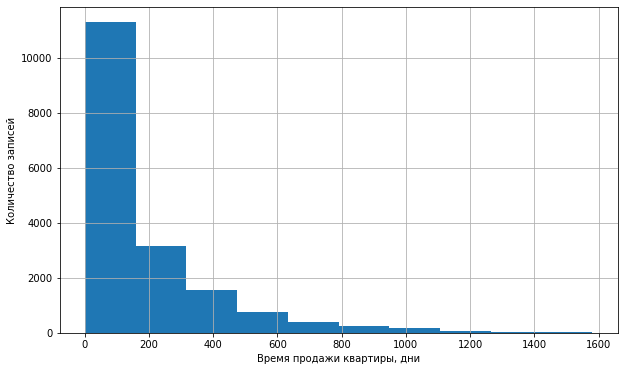

Среднее время продажи жилья: 183.52 дней
Медианное время продажи жилья: 100.00 дней
Количество записей с временем продажи больше 3 лет: 144


In [163]:
plt.figure(figsize=(10,6))
real_estate_df['days_exposition'].plot(kind='hist', grid=True)
plt.xlabel('Время продажи квартиры, дни')
plt.ylabel('Количество записей')
plt.show()
print('Среднее время продажи жилья: {:.2f} дней'.format(real_estate_df['days_exposition'].mean()))
print('Медианное время продажи жилья: {:.2f} дней'.format(real_estate_df['days_exposition'].median()))
print('Количество записей с временем продажи больше 3 лет: {}'.format(len(real_estate_df.query('days_exposition > 1100'))))

Мы видим, что среднее значение почти в два раза больше медианного. Это говорит нам о том, что в данных есть аномально большие значения. Тяжелый хвост гистограммы это подтверждает. Построим boxplot, чтобы лучше увидеть данные. Заодно посмотрим на их распрределение по населенным пунктам.

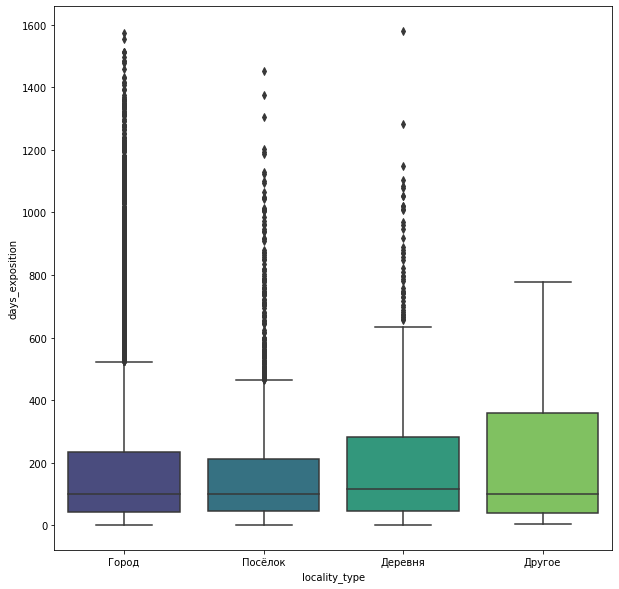

In [164]:
plt.figure(figsize=(10,10))
sns.boxplot(x=real_estate_df['locality_type'], y=real_estate_df['days_exposition'], orient='vertical', palette='viridis')

Медианы у всех 4 категорий находятся примерно на одном и том же уровне, соответственно, среднее время продажи ближе к 100 дням, нежели к среднему по выборки со значением 183 дня. Выбросы есть буквально в каждой категории за исключением категории "Другое". Это объясняется тем, что там достаточно мало данных.

Посмотрим на некоторые факторы, которые могут влиять на стоимость квартиры.

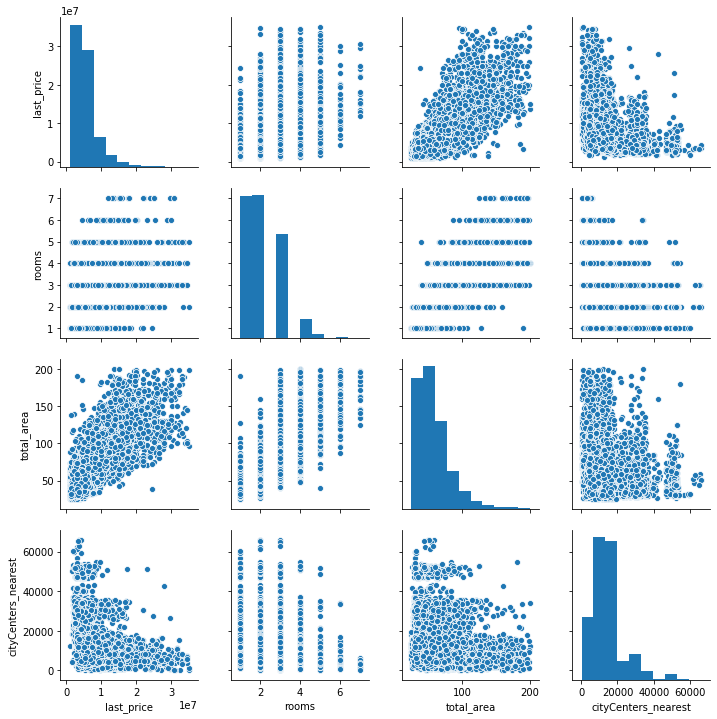

In [165]:
sns.pairplot(real_estate_df[['last_price', 'rooms', 'total_area', 'cityCenters_nearest']])

Похоже, что цена коррелирует с расстоянем до центра. Посмотрим на более детальный график.

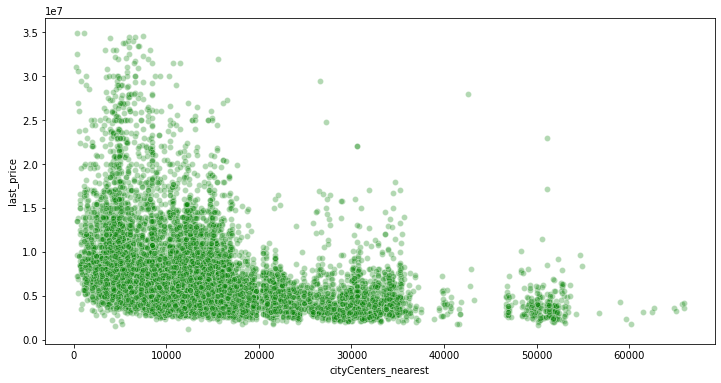

In [166]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='cityCenters_nearest', y='last_price', data=real_estate_df, color='g', alpha=0.3)
plt.show()

Действительно, при удалении от центра стоимость жилья убывает.

Теперь проверим, есть ли корреляция между ценой c датой размещения и с типом этажа.

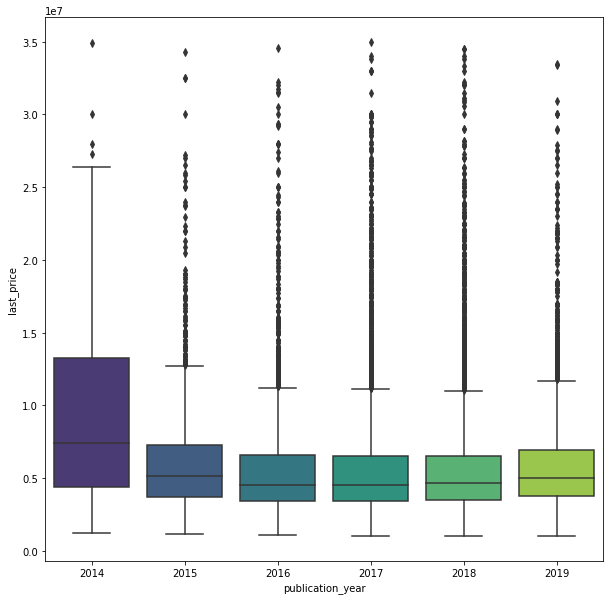

2018    7191
2017    7186
2019    2557
2016    2419
2015    1006
2014     122
Name: publication_year, dtype: int64

In [167]:
plt.figure(figsize=(10,10))
sns.boxplot(x='publication_year', y='last_price', data=real_estate_df, palette='viridis')
plt.show()
real_estate_df['publication_year'].value_counts()

На первый взгляд кажется, что цены жилья в 2014 были в среднем выше, однако это скорее всего из-за того, что в этой категории всего 122 объекта. Во все последующие годы все более менее одинаково. Некоторые колебания можно списать на постоянное измение цен на рынке недвижимости. Проверим распределение цен по месяцам и дням недели.

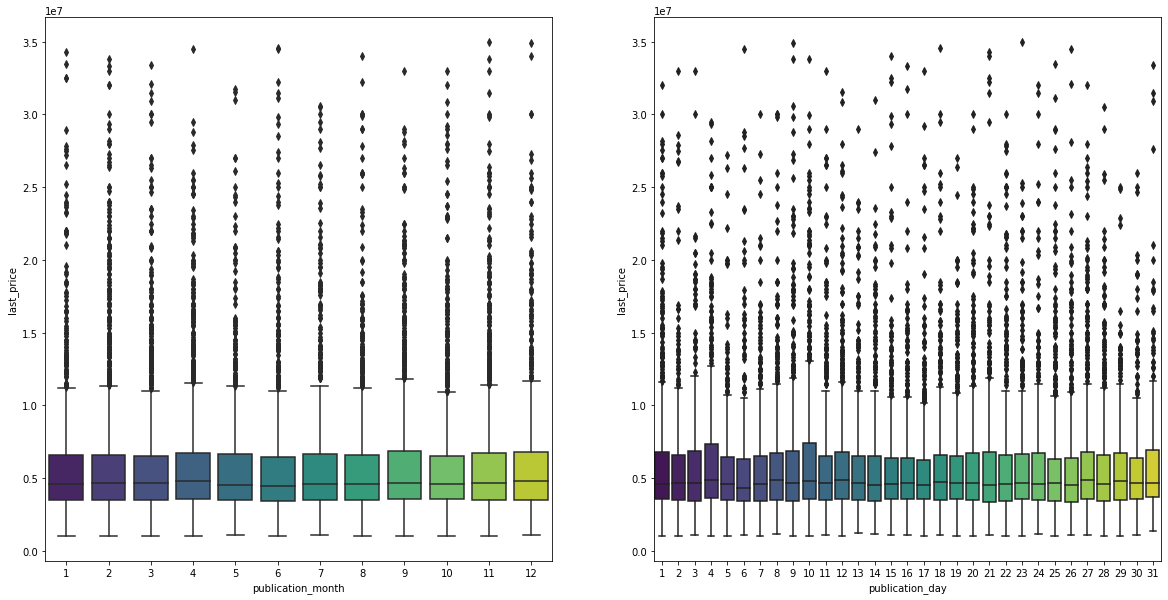

In [168]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.boxplot(x='publication_month', y='last_price', data=real_estate_df, palette='viridis')
plt.subplot(1,2,2)
sns.boxplot(x='publication_day', y='last_price', data=real_estate_df, palette='viridis')
plt.show()

Данные распределены равномерно.

В завершении посмотрим на тип этажа.

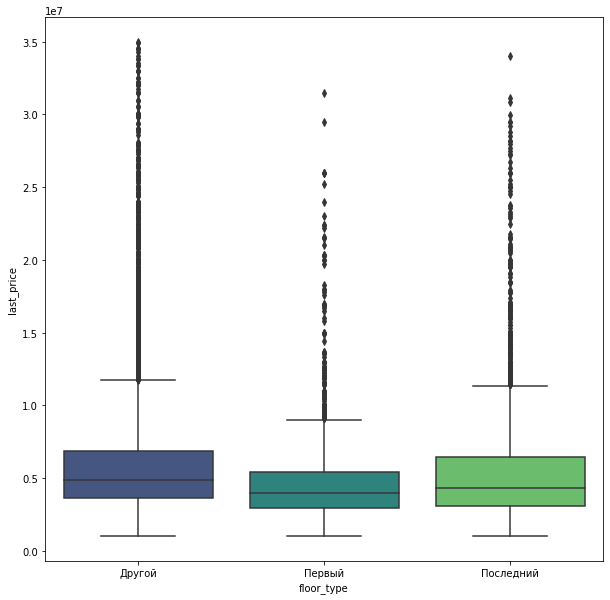

Другой       15177
Последний     2826
Первый        2478
Name: floor_type, dtype: int64

In [169]:
plt.figure(figsize=(10,10))
sns.boxplot(x='floor_type', y='last_price', data=real_estate_df, palette='viridis')
plt.show()
real_estate_df['floor_type'].value_counts()

Отсюда видно, что первый этаж в среднм стоит дешевле по сравнению с другими категориями, однако эта гипотеза требует проверки.

Продолжая анализ выберем 10 населённых пунктов с наибольшим числом объявлений и посчитаем для них среднюю цену за квадратный метр.

In [170]:
top_localities = real_estate_df.pivot_table(index='locality_name', values='price_per_m2', aggfunc=['count', 'mean'])\
                                                         .sort_values(by=('count', 'price_per_m2'), ascending=False)
print(top_localities.head(10), '\n')
top_localities['locality_name'] = top_localities.index # делаем locality_name отдельным столбцом
max_price = top_localities[('mean', 'price_per_m2')].max()
min_price = top_localities[('mean', 'price_per_m2')].min()
print("Максимальная цена за кв.м: {:.2f} р, населенный пункт: {}."\
      .format(max_price, top_localities[top_localities[('mean', 'price_per_m2')] == max_price]['locality_name'][0]))
print("Минимальная цена за кв.м: {:.2f} р, населенный пункт: {}."\
      .format(min_price, top_localities[top_localities[('mean', 'price_per_m2')] == min_price]['locality_name'][0]))

                         count           mean
                  price_per_m2   price_per_m2
locality_name                                
Санкт-Петербург          13728  110153.605228
посёлок Мурино             420   85232.315709
посёлок Шушары             396   78387.716088
Всеволожск                 354   69027.826290
Пушкин                     325  102646.893932
Колпино                    320   75149.010155
Гатчина                    292   68946.880140
посёлок Парголово          288   90727.203363
деревня Кудрово            230   92143.905537
Петергоф                   190   83754.411729 

Максимальная цена за кв.м: 127678.57 р, населенный пункт: посёлок Репино.
Минимальная цена за кв.м: 15642.46 р, населенный пункт: поселок Житково.


Теперь посмотрим данные Санкт-Петербурга и постараемся определить центральную зону города, основываясь на данных о стоимости жилья. Для начала сделаем отдельный датасет, в который будут входить только жилые объекты Санкт-Петербурга.

In [171]:
spb_data = real_estate_df.query('locality_name == "Санкт-Петербург"')

Проверим отсутствующие значения в характеристике 'расстояние до центра' и уберем их, если они есть.

In [172]:
spb_data['cityCenters_nearest'].isnull().sum()

39

In [173]:
spb_data = spb_data.dropna(subset=['cityCenters_nearest']).reset_index(drop=True)

Добавим новый столбец данных - количество километров до центра города.

In [174]:
spb_data['kilometers_to_center'] = (spb_data['cityCenters_nearest'] / 1000).astype(np.uint8)

Создадим еще один столбец, где будет посчитана средняя цена за каждый километр.

In [175]:
price_per_km = dict(spb_data.groupby('kilometers_to_center')['last_price'].mean())
spb_data['price_per_km'] = spb_data['kilometers_to_center'].apply(lambda x: price_per_km[x]) 

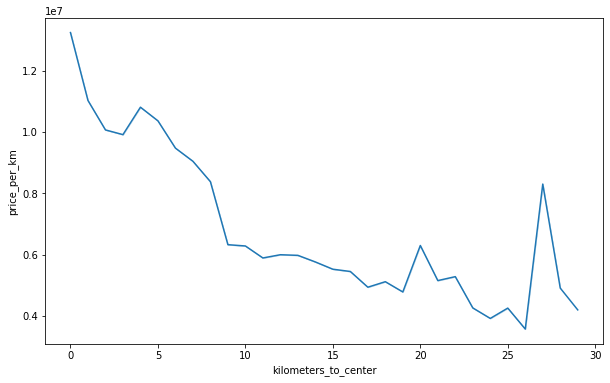

In [176]:
plt.figure(figsize=(10,6))
sns.lineplot(x='kilometers_to_center', y='price_per_km', data=spb_data)
plt.show()

Резкий скачок в цене происходит в районе 8 км. Средняя цена за следующий километр падает с 8 млн. до 6 млн. Таким образом, все, что находится в радиусе 8 км от самого центра города - центральная зона. Скачок в районе 26-28 км от центра может быть связан с так называемой зоной субурбии - частные застройки дачного типа.

### Количественная оценка стоимости квартиры

Хорошо бы оценить каждый из параметров количественно, чтобы в случае поступления новых данных сразу дать финальную оценку стоимости. Для этого я обучу простую модель машинного обучения (линейную регрессию).

Для начала, отберем характеристики, которые мы будем использовать для прогноза и разделим данные на тренировочную и тестовую выборку.

In [177]:
real_estate_df = real_estate_df.dropna(subset=['cityCenters_nearest'])

Теперь данные почти готовы для обучения модели. Категориальные переменные типа object нужно перевести в дамми переменные.

In [178]:
scaler = StandardScaler()

In [179]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15942 entries, 0 to 23697
Data columns (total 27 columns):
total_images            15942 non-null uint8
last_price              15942 non-null int32
total_area              15942 non-null float16
first_day_exposition    15942 non-null datetime64[ns]
rooms                   15942 non-null uint8
ceiling_height          15942 non-null float16
floors_total            15942 non-null uint8
living_area             15942 non-null float16
floor                   15942 non-null uint8
studio                  15942 non-null bool
open_plan               15942 non-null bool
kitchen_area            15942 non-null float16
balcony                 15942 non-null uint8
locality_name           15942 non-null object
airports_nearest        15923 non-null float64
cityCenters_nearest     15942 non-null float64
parks_around3000        15942 non-null float64
parks_nearest           6942 non-null float64
ponds_around3000        15942 non-null float64
ponds_neare

In [180]:
real_estate_df = real_estate_df.dropna(subset=['cityCenters_nearest', 'airports_nearest'])
real_estate_df['kilometers_to_center'] = (real_estate_df['cityCenters_nearest'] / 1000).astype(np.uint8)
real_estate_df = real_estate_df.drop(['studio',
                                      'open_plan',
                                      'parks_nearest',
                                      'ponds_nearest',
                                      'price_per_m2',
                                      'first_day_exposition',
                                      'locality_name',
                                      'days_exposition',
                                      'total_images',
                                      'cityCenters_nearest'], axis=1)
real_estate_df = pd.get_dummies(real_estate_df, columns=['rooms', 'balcony', 'locality_type', 'floor_type'])

На всякий случай проверим, есть ли в данных дубликаты.

In [181]:
real_estate_df.duplicated().sum()

0

In [182]:
X = real_estate_df.drop('last_price', axis=1)
X = scaler.fit_transform(X)
y = real_estate_df['last_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Создаем инстанс модели. В результате работы GridSearchCV были получены следующие коэффициенты: alpha=1, L1_ratio=0.9

In [183]:
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.9)

Обучим модель на тренировочных данных.

In [184]:
elastic_model.fit(X_train, y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Построим словарь, где ключом является название столбца, а значение - количественная оценка вкалада конкретного параметра в стоимость жилья.

In [185]:
coefs_elasric = elastic_model.coef_
coefs_new = dict(zip(real_estate_df.columns[1:], coefs_elasric))
coefs_new

{'total_area': 3135075.7647610144,
 'ceiling_height': 148170.2638329233,
 'floors_total': -73314.73358948757,
 'living_area': 340966.4219653213,
 'floor': 83491.2360031949,
 'kitchen_area': 637330.2704243495,
 'airports_nearest': 70656.5397981582,
 'parks_around3000': 176403.9122266054,
 'ponds_around3000': 131477.6661306014,
 'publication_year': 208639.96356045696,
 'publication_month': 39795.98244851809,
 'publication_day': 24729.34834396678,
 'kilometers_to_center': -573030.0596530389,
 'rooms_1': 447018.8456971625,
 'rooms_2': 130075.9648227422,
 'rooms_3': -287275.04089795303,
 'rooms_4': -378022.14034609497,
 'rooms_5': -395508.6319387301,
 'rooms_6': -264660.307743579,
 'rooms_7': -102693.19312341367,
 'balcony_0': -26734.87435202439,
 'balcony_1': 8597.030978637882,
 'balcony_2': 17750.43645963223,
 'balcony_3': -26461.089285977134,
 'balcony_4': 45693.047133020926,
 'balcony_5': 3871.7712357280966,
 'locality_type_Город': 95197.70833410019,
 'locality_type_Посёлок': -95196.256

Заодно посмотрим на предсказания модели по тестовой выборке, чтобы убедить в ее адекватной работе.

In [186]:
predictions = elastic_model.predict(X_test)

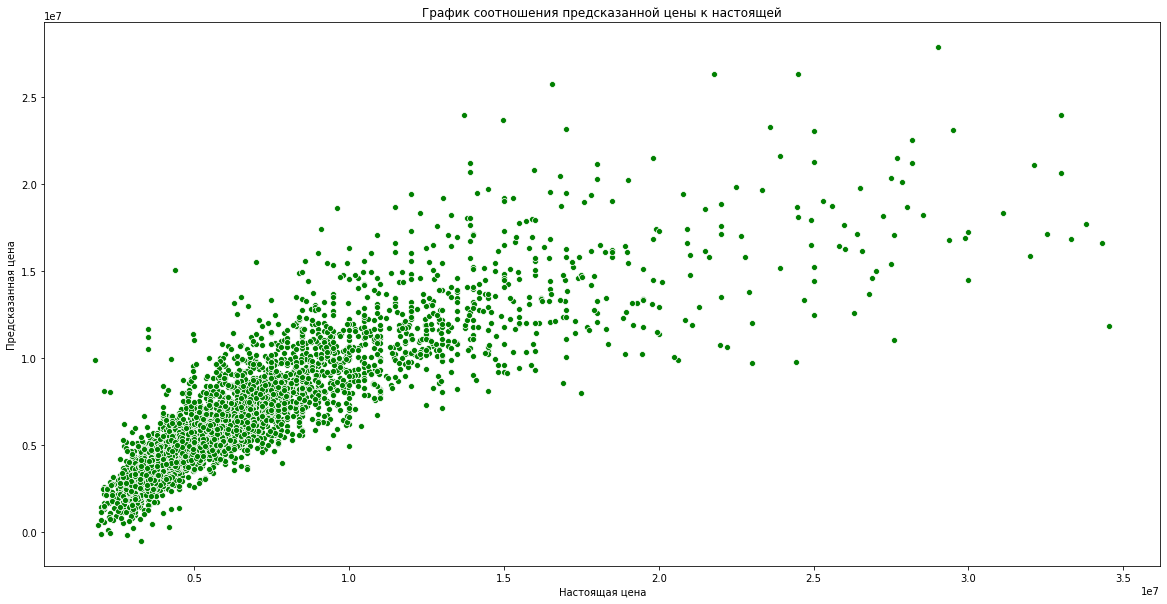

In [187]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(y_test, predictions, color='g')
plt.xlabel("Настоящая цена")
plt.ylabel("Предсказанная цена")
plt.title("График соотношения предсказанной цены к настоящей")
plt.show()

Оценим корень среднеквадратичной ошибки данных.

In [188]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Корень среднеквадратичной ошибки: {:.2f}'.format(rmse))

Корень среднеквадратичной ошибки: 2069872.63


В среднем мы ошибались на 2.069.872 р, но эти цифры мало о чем нам говорят. Посмотрим немного другую интерпретацию.

In [189]:
avg_error = (abs(y_test - predictions) / y_test).mean()
print('Средняя ошибка : {:.2%}'.format(avg_error))

Средняя ошибка : 18.18%


Это значит, что в среднем наши результаты отличались на 18.23% от правильных. Значит, наша модель работает и работает нормально, а следовательно, мы можем доверять количественным коэффициентам. Посмотрим на них еще раз.

In [190]:
coefs_new

{'total_area': 3135075.7647610144,
 'ceiling_height': 148170.2638329233,
 'floors_total': -73314.73358948757,
 'living_area': 340966.4219653213,
 'floor': 83491.2360031949,
 'kitchen_area': 637330.2704243495,
 'airports_nearest': 70656.5397981582,
 'parks_around3000': 176403.9122266054,
 'ponds_around3000': 131477.6661306014,
 'publication_year': 208639.96356045696,
 'publication_month': 39795.98244851809,
 'publication_day': 24729.34834396678,
 'kilometers_to_center': -573030.0596530389,
 'rooms_1': 447018.8456971625,
 'rooms_2': 130075.9648227422,
 'rooms_3': -287275.04089795303,
 'rooms_4': -378022.14034609497,
 'rooms_5': -395508.6319387301,
 'rooms_6': -264660.307743579,
 'rooms_7': -102693.19312341367,
 'balcony_0': -26734.87435202439,
 'balcony_1': 8597.030978637882,
 'balcony_2': 17750.43645963223,
 'balcony_3': -26461.089285977134,
 'balcony_4': 45693.047133020926,
 'balcony_5': 3871.7712357280966,
 'locality_type_Город': 95197.70833410019,
 'locality_type_Посёлок': -95196.256

Не все данные имеют адекватное количественное значение, но общая тенденция (что влияет на рост цены, а что наоборот снижает цену) видна четко. Мы видим, что сильнее всего на рост цены влият общая площадь, что весьма логично. Также, чем больше высота потолка, жилая площадь, площадь, отведенная под кухню, количество парков и озер. Обратим внимание, что сказывается влияение года публикации что может быть связано с инфляцией (день и месяц публикации влияют незначительно). Чем меньше квартир в квартире - тем лучше это сказывается на стоимости (двушки и однушки добавляют стоимость, квартиры с большим количеством комнат - отнимают). Четко видно, что чем дальше квартира от центра, тем меньше ее стоимость. Количество балконов влияет неявно. Можно отметить тот факт, что квартиры в городе стоят дороже квартир в поселке и расположение квартиры на первом или последнем этаже уменьшает стоимость жилья.

### Общий вывод

Данные были очищены: некоторые пропущенные значения были заполнены, некоторые удалены; избавились от обнаруженных аномалий. Также мы оптимизировали типы данных в результате чего на 32% сократили память, занимаемую датасетом. В результате проведенного анализа мы выяснили на какие показатели стоит опираться при построении автоматической системы (общая площадь, высота потолка, расстояние до центра, количество комнат и где расположено жилье), оценивающей стоимость жилья и даже построили небольшой ее аналог. Помимо этого, на основании имеющихся данных мы смогли определить центральную зону Санкт-Петербурга, радиус которой составляет 8 км от центра города. Все ключевые рассчеты были подкреплены графиками.